In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import scipy.cluster.hierarchy as sch

import paragami

# GMM regression libraries
# regression-mixture libraries
from bnpreg_runjingdev import genomics_data_utils
from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

import regression_plotting_utils

# BNP libraries
from bnpmodeling_runjingdev import result_loading_utils

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

In [3]:
# TODO: put this class in a library
import sys
sys.path.insert(0, '../../GMM_clustering/jupyter/')
from gmm_loading_utils import GMMResultsLoader

# Load data

In [4]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, regressors, beta, beta_infos, y_infos = \
    genomics_data_utils.load_data_and_run_regressions(bnp_data_repo)
n_genes = genome_data.shape[0]
reg_dim = regressors.shape[1]

n_timepoints = len(np.unique(timepoints))

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


# File paths

In [5]:
out_folder = '../fits/'
out_filename = 'mice_genomics_fit'
alpha0 = 6.0

In [6]:
# class with method to load all files from a particular perturbation
gmm_result_loader = GMMResultsLoader(alpha0, 
                                 out_folder, 
                                 out_filename)

loading initial fit from:  ../fits/mice_genomics_fit_alpha6.0.npz
loading lr derivatives from:  ../fits/mice_genomics_fit_alpha6.0_lrderivatives.npz


### Some meta data and model parameters

In [7]:
vb_init_free = gmm_result_loader.vb_init_free
vb_params_paragami = gmm_result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [8]:
# gauss-hermite parameters
gh_deg = int(gmm_result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = regression_mixture_lib.get_default_prior_params()

# set initial alpha
assert alpha0 == gmm_result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_centroid_info': DeviceArray([0.1], dtype=float64), 'prior_shift_mean': DeviceArray([0.], dtype=float64), 'prior_shift_info': DeviceArray([0.1], dtype=float64), 'prior_data_info_shape': DeviceArray([10.], dtype=float64), 'prior_data_info_scale': DeviceArray([0.1], dtype=float64)}


### Make some plots of the initial fit

In [9]:
ez_init = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data, regressors,
                                                   vb_init_dict,
                                                   prior_params_dict, 
                                                   gh_loc, gh_weights)[0]

e_num_obs_per_cluster = ez_init.sum(0)
mixture_weights = reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_init_dict, gh_loc, gh_weights)

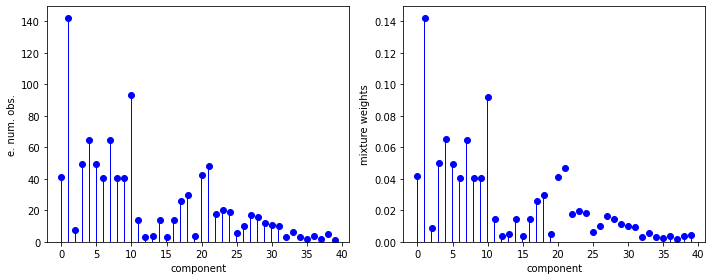

In [10]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


In [11]:
def plot_top_clusters(vb_params_dict, ez): 
    
    ##############
    # Get estimates
    ##############
    
    top_clusters_sorted = np.argsort(-e_num_obs_per_cluster)
    
    # centroids
    est_centroids = vb_params_dict['centroids']
    
    # shifts
    est_shifts = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data,
                                                                            regressors,
                                                                            vb_params_dict,
                                                                            prior_params_dict, 
                                                                            gh_loc, gh_weights)[2]
    
    # average observations across replicates 
    # for plotting
    mean_operator = onp.zeros((genome_data.shape[1], n_timepoints))
    for i in range(n_timepoints): 
        mean_operator[3*i:((i+1)*3), i] = 1/3

    unique_timepoints = np.unique(timepoints)
    _y = np.dot(genome_data, mean_operator)
    
    
    ###############
    # PLOT
    ###############
    f, axarr = plt.subplots(2, 3, figsize=(15,8))

    for i in range(6):
        which_cluster = top_clusters_sorted[i]

        # genes in this cluster
        which_genes = np.argwhere(ez.argmax(1) == which_cluster).squeeze()

        this_plot = axarr[int(np.floor(i / 3)), i % 3]

        this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
        this_plot.set_xlabel('time')
        this_plot.set_ylabel('gene expression (shifted)')

        # Plot genes in this cluster
        for n in which_genes: 
            this_plot.plot(unique_timepoints, _y[n] - est_shifts[n, which_cluster],
                           color = 'grey')

        # plot centroid
        regression_plotting_utils.plot_prediction_line(timepoints, 
                                                       regressors, 
                                                       est_centroids[which_cluster], 
                                                       ax = this_plot, 
                                                       linewidth = 5, 
                                                       color = 'green')


    f.tight_layout()


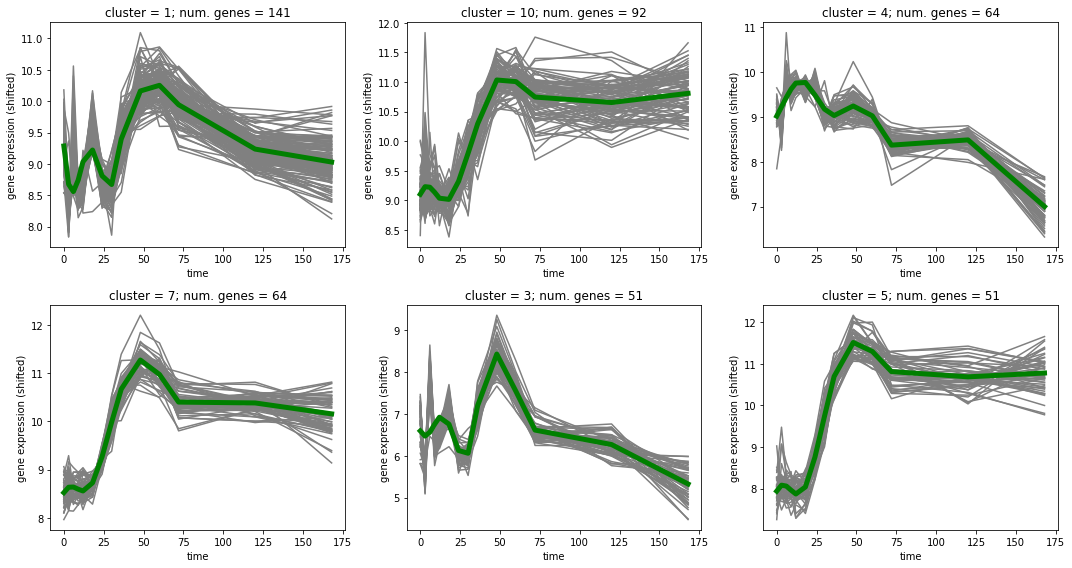

In [12]:
plot_top_clusters(vb_init_dict, ez_init)

# Posterior statistics

### Thresholded expected number of clusters

In [14]:
threshold = 5
prng_key = jax.random.PRNGKey(223)

In [15]:
@jax.jit
def get_n_clusters_insample_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return reg_posterior_quantities.get_e_num_clusters_from_vb_dict(genome_data,
                                                                    regressors,
                                                                    vb_params_dict,
                                                                    prior_params_dict,
                                                                    gh_loc, gh_weights,
                                                                    threshold = threshold,
                                                                    n_samples = 1000, 
                                                                    prng_key = prng_key)

@jax.jit
def get_n_clusters_pred_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return reg_posterior_quantities.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                        n_obs = genome_data.shape[0],
                                                        threshold = threshold,
                                                        n_samples = 1000, 
                                                        prng_key = prng_key)

### Mixture weights

In [16]:
@jax.jit 
def get_mixture_weights(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    mixture_weights = reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_params_dict,
                                                                 gh_loc,
                                                                 gh_weights)
    
    return mixture_weights

### expected number of observations per cluster

In [17]:
@jax.jit
def get_e_num_obs_per_cluster(vb_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    ez = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data, regressors,
                                                   vb_params_dict,
                                                   prior_params_dict, 
                                                   gh_loc, gh_weights)[0]
    
    return ez.sum(0)

# Function to make trace plot of cluster weights

We plot an array of these, so using the default trace-plotter is a bit slow ... 

In [18]:
def plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, vb_refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(epsilon_vec, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(epsilon_vec, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k))
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('epsilon')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# obs)')
    
    fig.tight_layout()


# Function to plot results

In [28]:
def plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [-1]): 
    
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        gmm_result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    #################
    # in-sample number of clusters
    #################
    fig, ax = plt.subplots(1, 4, figsize = (16, 3))
    result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample_thresh, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[0])
    ax[0].set_title('in-sample; thresh = {}'.format(threshold))
    ax[0].legend()
    
    #################
    # predictive number of clusters
    #################
    result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred_thresh, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[2])
    ax[2].set_title('predictive; thresh = {}'.format(threshold))
        
    #################
    # expected number of individuals per cluster
    #################
    result_loading_utils.\
        plot_mixture_weights(get_e_num_obs_per_cluster(vb_refit_list[-1]), 
                             get_e_num_obs_per_cluster(lr_list[-1]),
                             get_e_num_obs_per_cluster(lr_list[0]), 
                             ax[1])
    # ax[1].set_yscale('log')
    ax[1].set_title('e.num. obs per cluster')
    ax[1].axhline(threshold, color = 'grey')
    
    #################
    # mixture weights
    #################
    result_loading_utils.\
        plot_mixture_weights(get_mixture_weights(vb_refit_list[-1]) * n_genes, 
                             get_mixture_weights(lr_list[-1]) * n_genes,
                             get_mixture_weights(lr_list[0]) * n_genes, 
                             ax[3])
    # ax[3].set_yscale('log')
    ax[3].set_title('e.num. pred. obs per cluster')
    ax[3].axhline(threshold, color = 'grey')
    
    fig.tight_layout();
        
    # trace plot of mixture weights 
    plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec)

# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Optim time at epsilon = 1: 54.272secs
Derivative time: 3.053secs


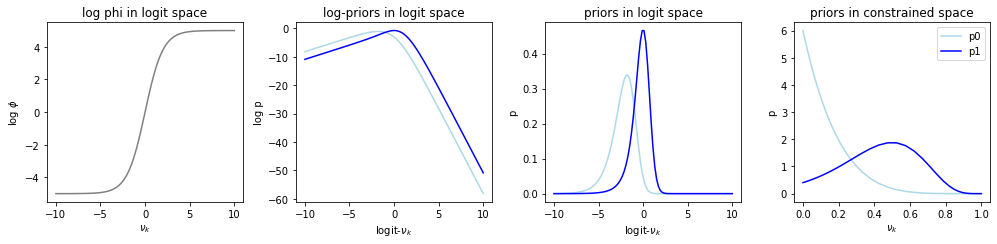

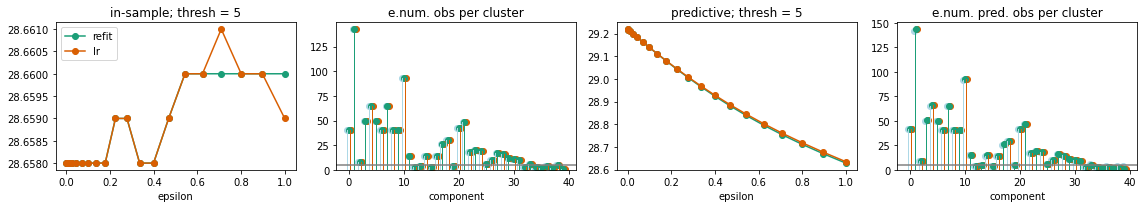

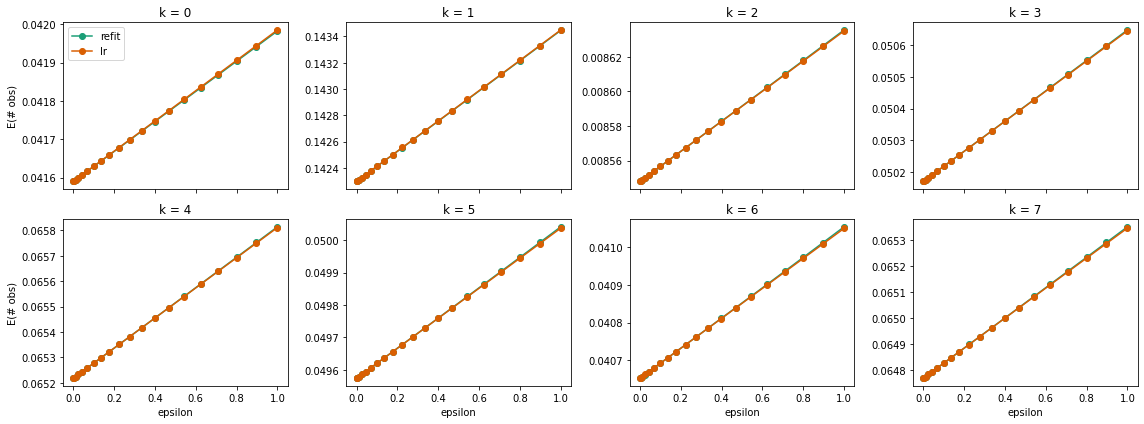

In [29]:
delta = 5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

Optim time at epsilon = 1: 66.304secs
Derivative time: 3.053secs


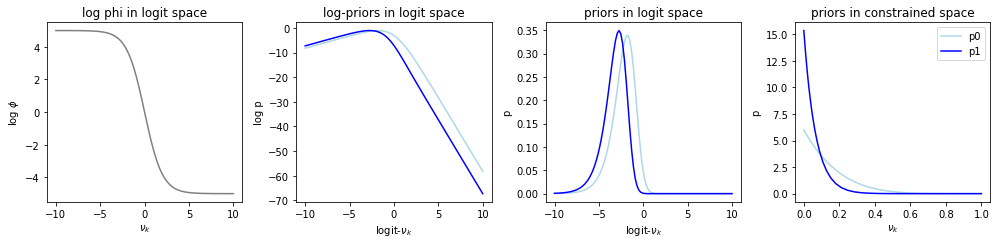

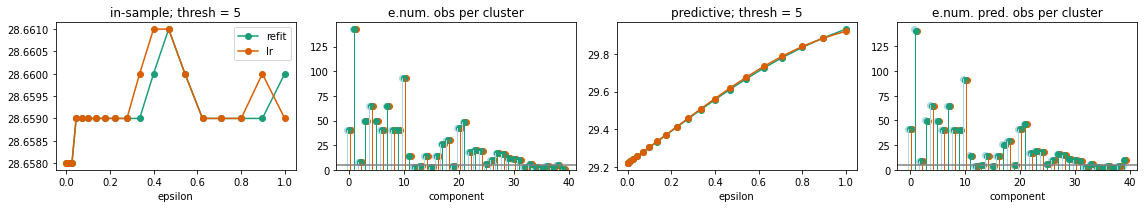

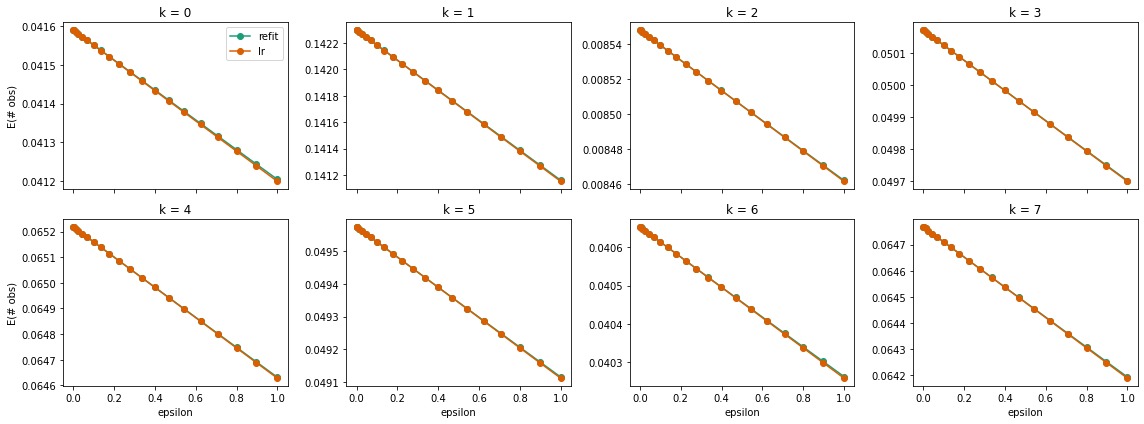

In [30]:
delta = -5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

# Alpha-type perturbations

Optim time at epsilon = 1: 33.036secs
Derivative time: 2.155secs


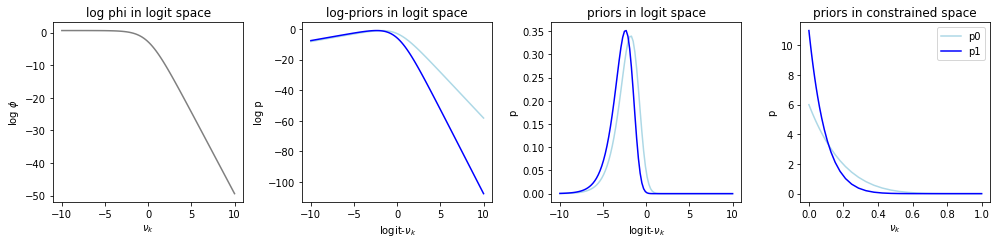

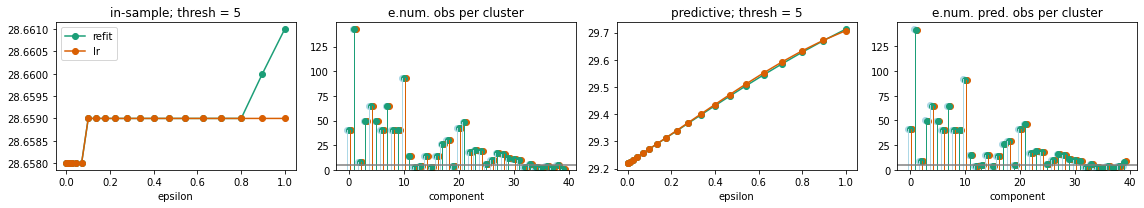

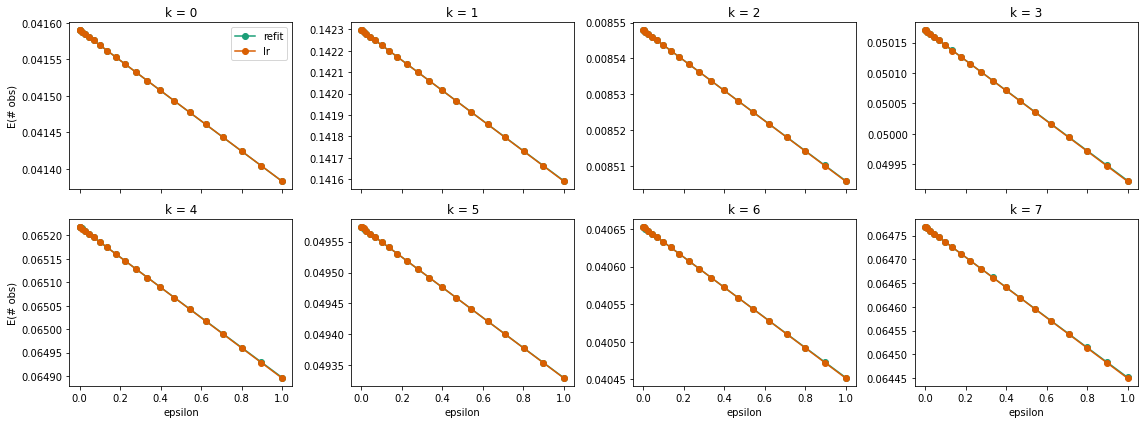

In [31]:
delta = 1
perturbation = 'alpha_pert_pos'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

Optim time at epsilon = 1: 32.860secs
Derivative time: 2.119secs


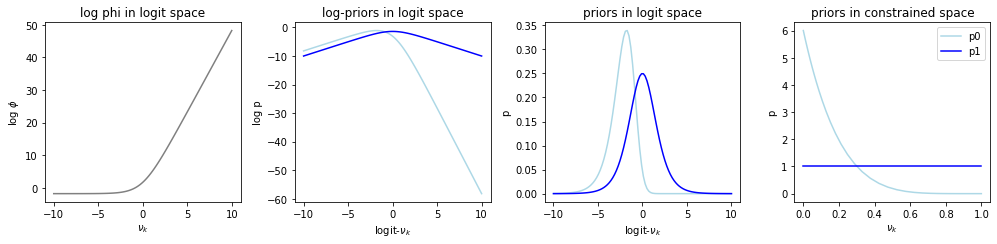

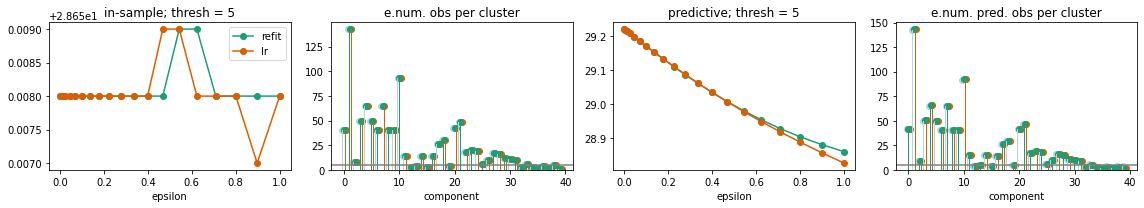

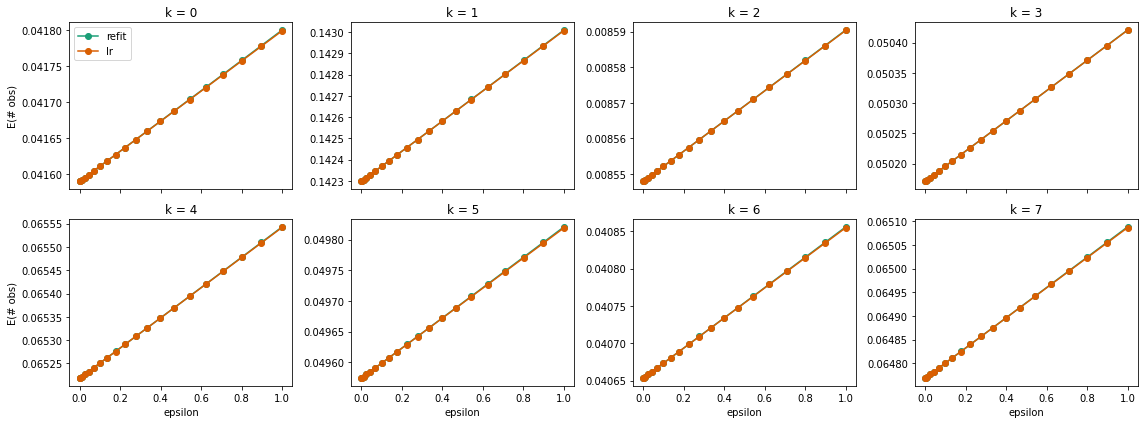

In [32]:
delta = 1
perturbation = 'alpha_pert_neg'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

# Gaussian bumps

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.362176e-04
  warnings.warn(


Optim time at epsilon = 1: 45.218secs
Derivative time: 4.003secs


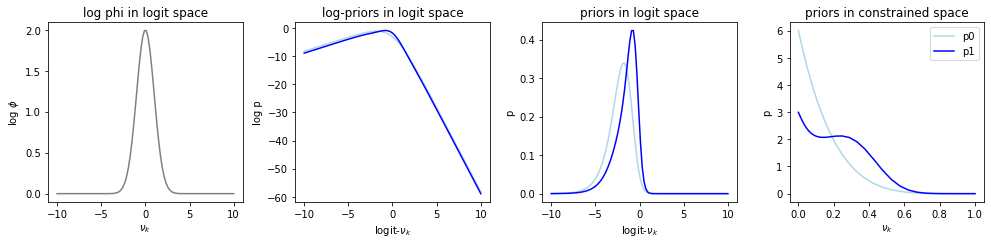

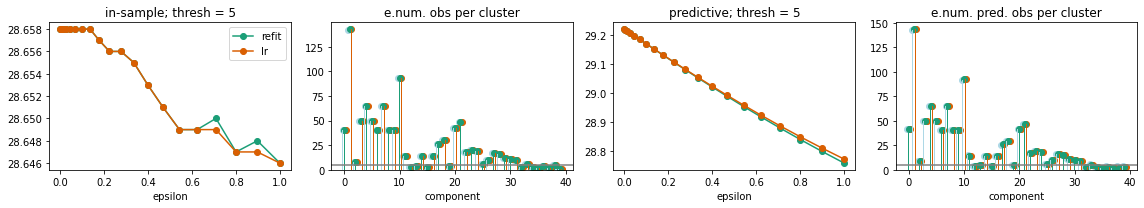

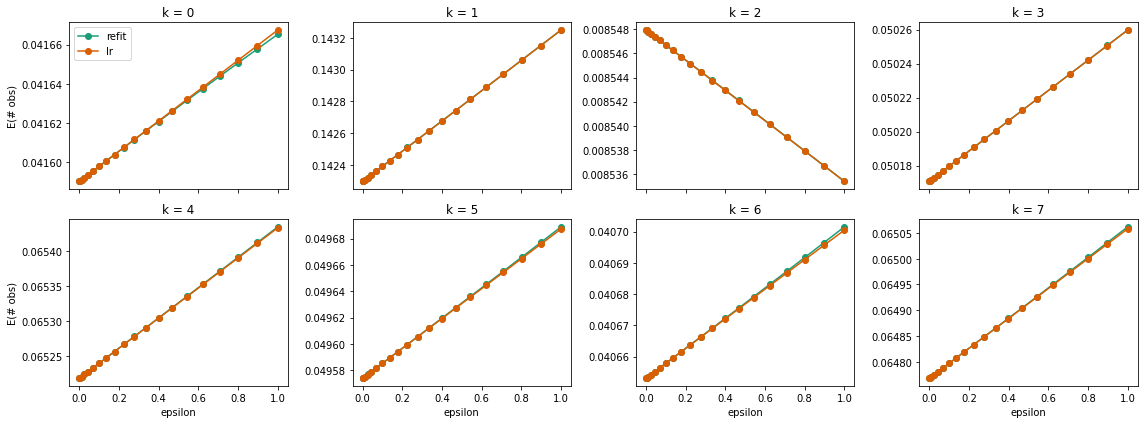

In [33]:
delta = 2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.070934e-06
  warnings.warn(


Optim time at epsilon = 1: 58.283secs
Derivative time: 4.003secs


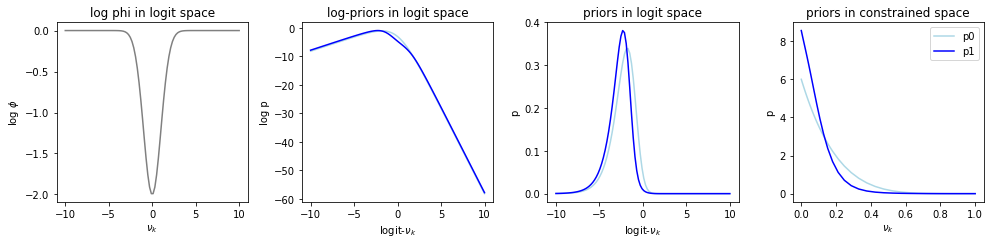

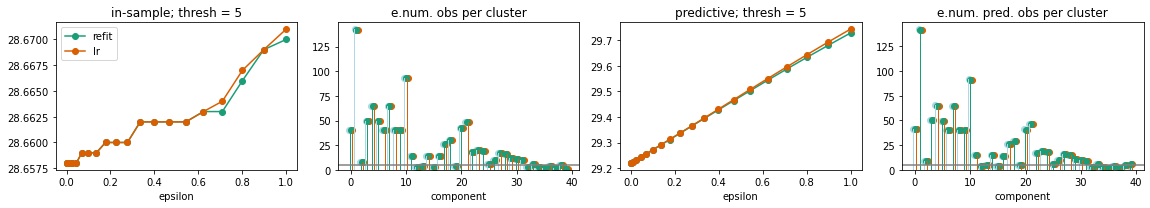

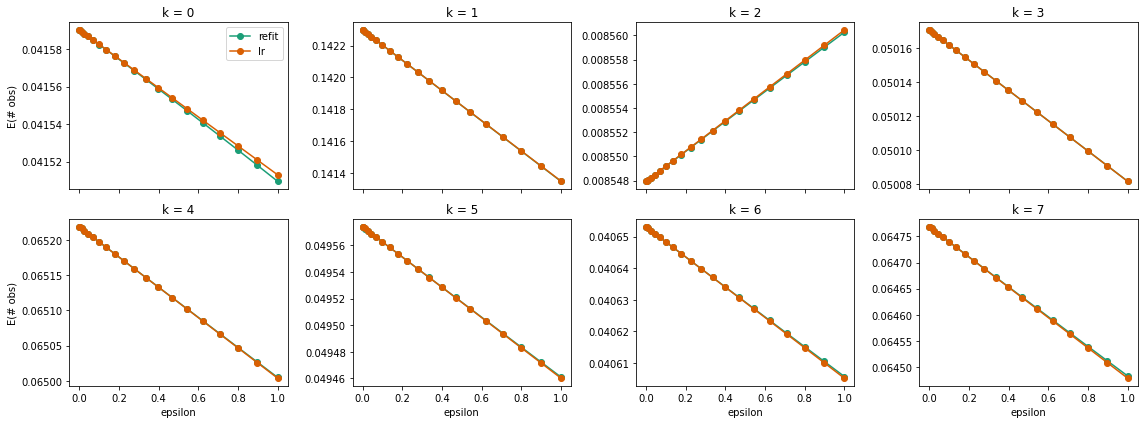

In [34]:
delta = -2
perturbation = 'gauss_pert1'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.091173e-05
  warnings.warn(


Optim time at epsilon = 1: 41.068secs
Derivative time: 5.029secs


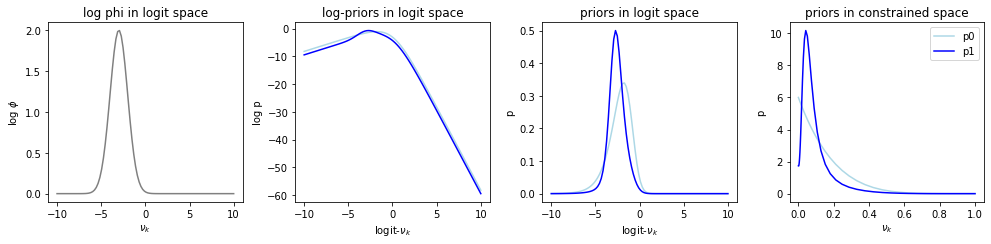

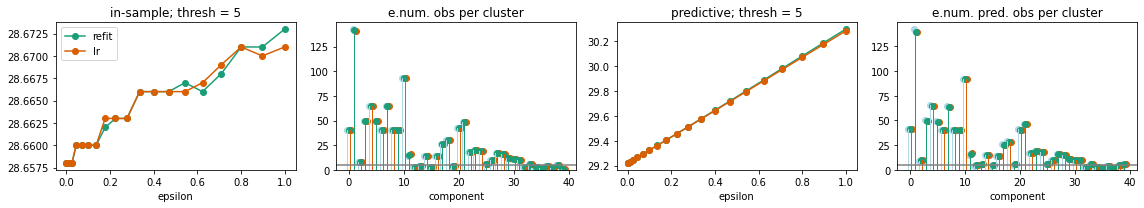

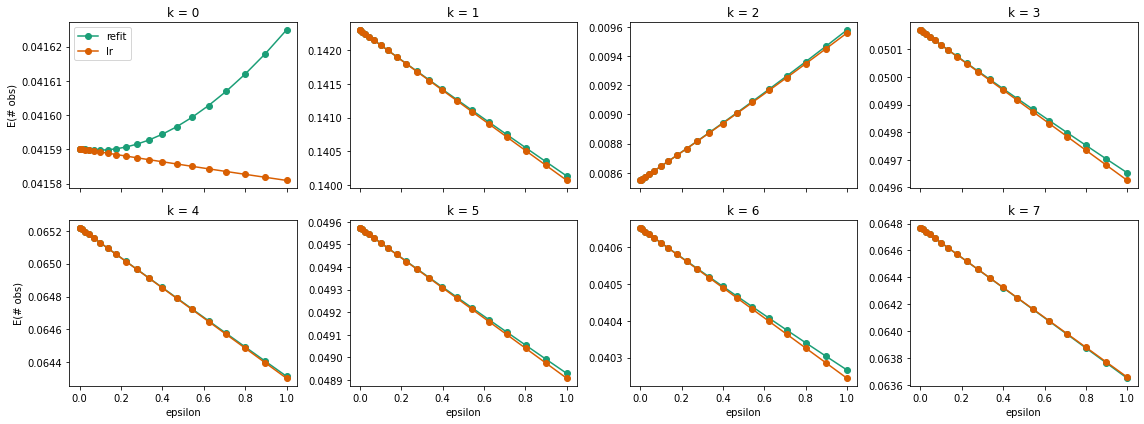

In [35]:
delta = 2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.327195e-07
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.136652e-07
  warnings.warn(


Optim time at epsilon = 1: 29.315secs
Derivative time: 5.029secs


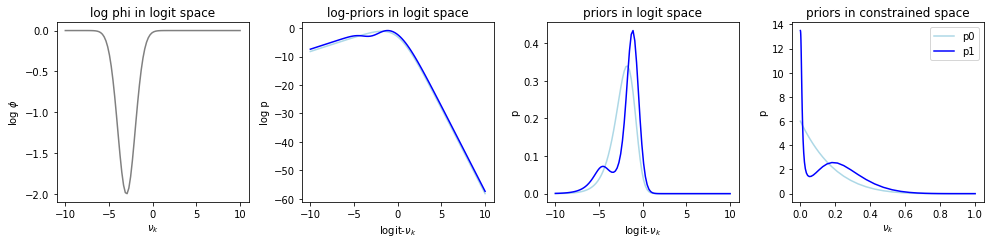

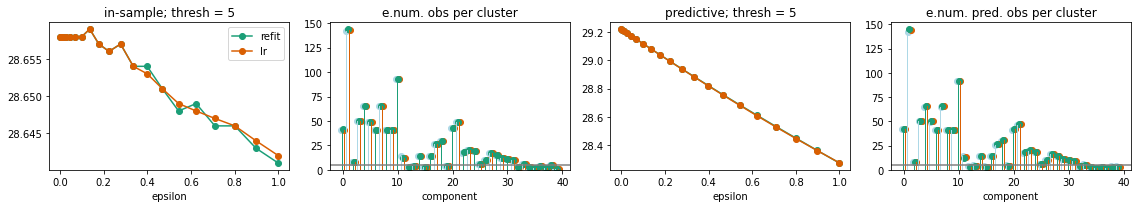

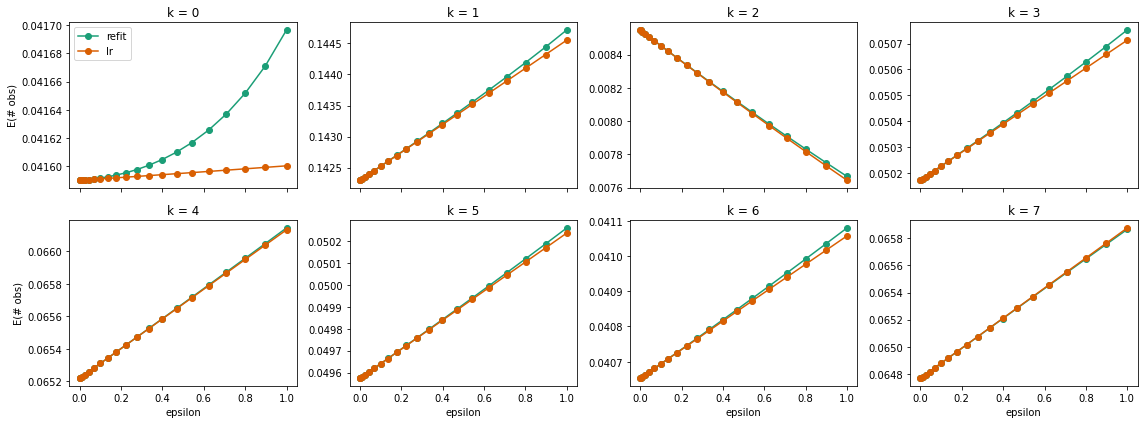

In [36]:
delta = -2
perturbation = 'gauss_pert2'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta, 
                              [10, 15, -1])